In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report

sys.path.insert(0, '..')

from config import *
from util.plot_utils import obtain_plot, plot_logs
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

In [3]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2')

In [4]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)

In [ ]:
res = pd.read_csv(os.path.join(checkpoint_dir, 'test_results.csv'))

print(classification_report(res.ground_truth, res.prediction))

# PLOTS

### Log plots

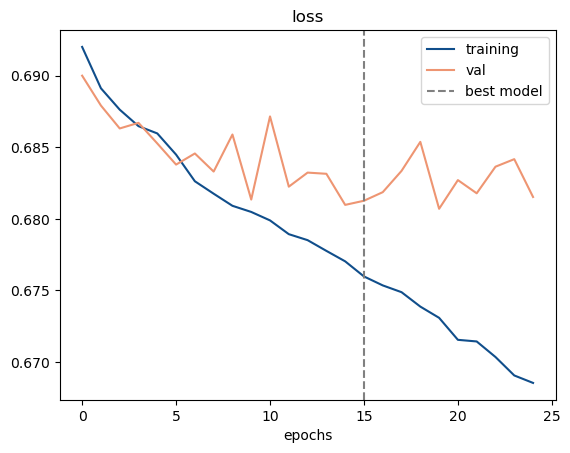

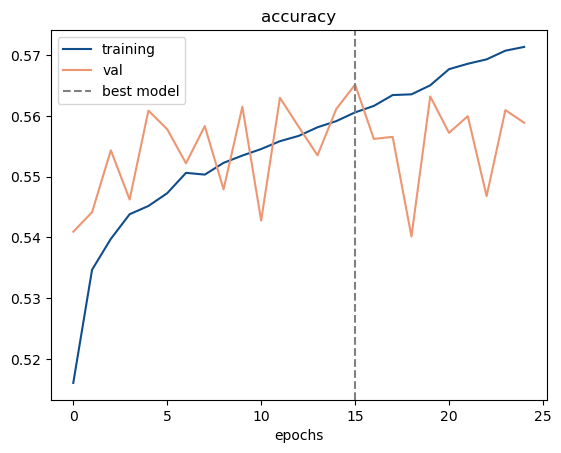

In [6]:
log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
best_model = np.argmax(log.test_accuracy)
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

## Metrics

In [12]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

1    15264
0     7715
Name: prediction, dtype: int64


0    11854
1    11125
Name: ground_truth, dtype: int64


In [13]:
n_conf = 10

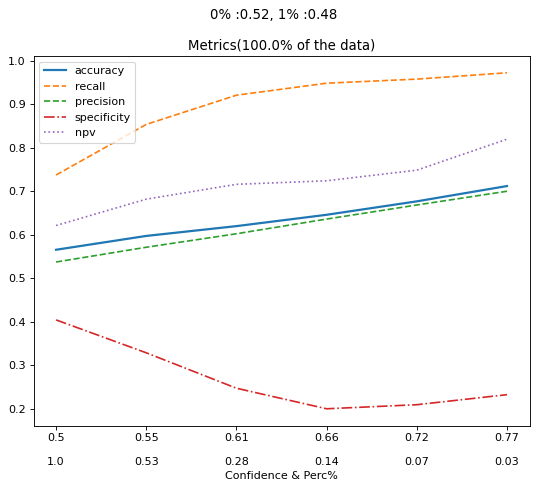

In [14]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

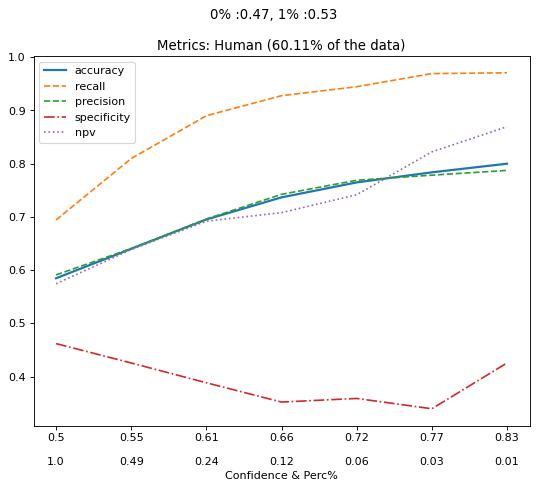

In [15]:
human = res[(res.specie == 'human')]
obtain_plot(human, n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

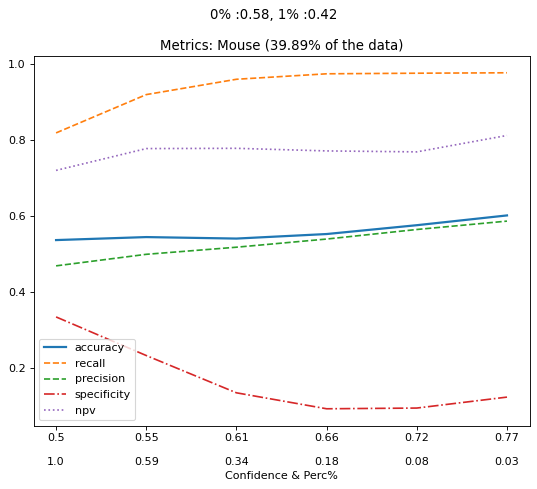

In [16]:
mouse = res[(res.specie == 'mouse')]
obtain_plot(mouse, n_original_df = res.shape[0], title = f'Metrics: Mouse ', n_conf = n_conf)

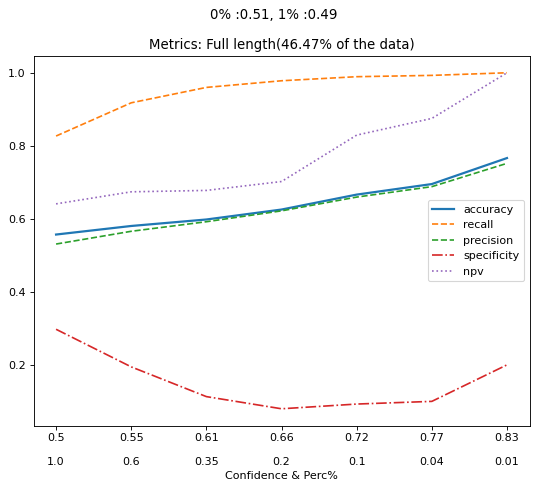

In [17]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
obtain_plot(full_length, n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

In [18]:
confidence_level = 0.66
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]

In [19]:
(high_conf_fl.ground_truth == high_conf_fl.prediction).sum() / high_conf_fl.shape[0]

0.6236263736263736

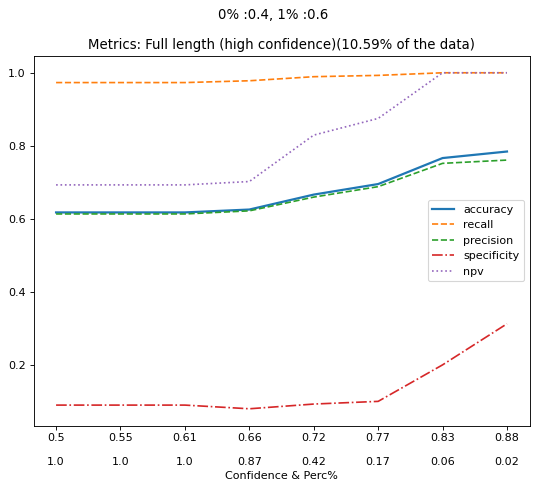

In [20]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
obtain_plot(high_conf_fl, n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf)

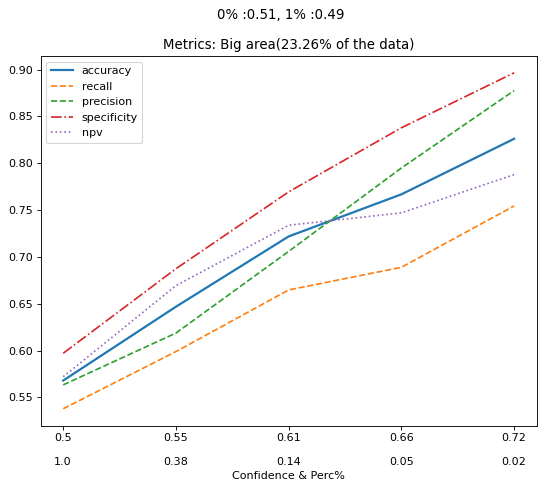

In [22]:
big_area_size = res.sampled_area.quantile(0.9)
big_area_size = 5000**2
big_area = res[res['sampled_area'] > big_area_size]

obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

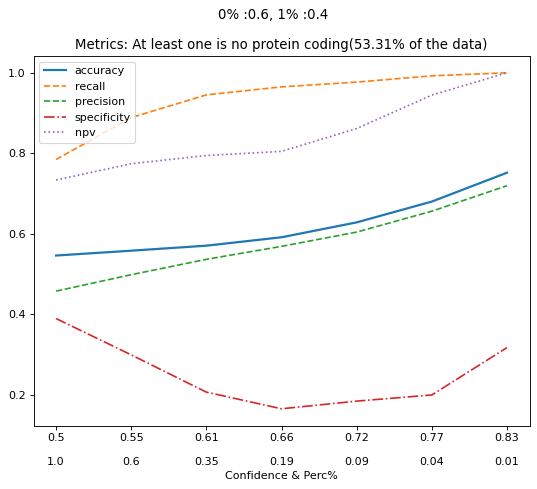

In [23]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(no_pc, n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.5565576850807967


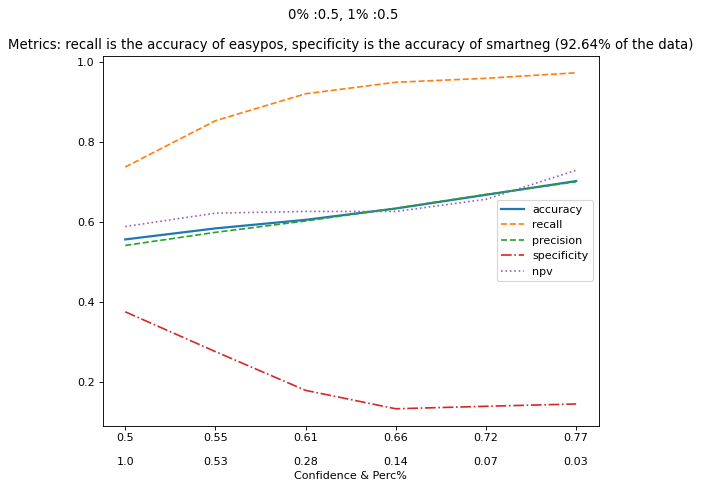

In [24]:
easypos_smartneg = res[(res.policy == 'easypos')|(res.policy == 'smartneg')]
vc = easypos_smartneg.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
easypos_gt = easypos_smartneg[easypos_smartneg.ground_truth==1]
id_to_exclude = list(easypos_gt.sample(frac = 1).head(n_to_exclude).id_sample)
easypos_smartneg_sampled = easypos_smartneg[~easypos_smartneg.id_sample.isin(id_to_exclude)]
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)

0.609375


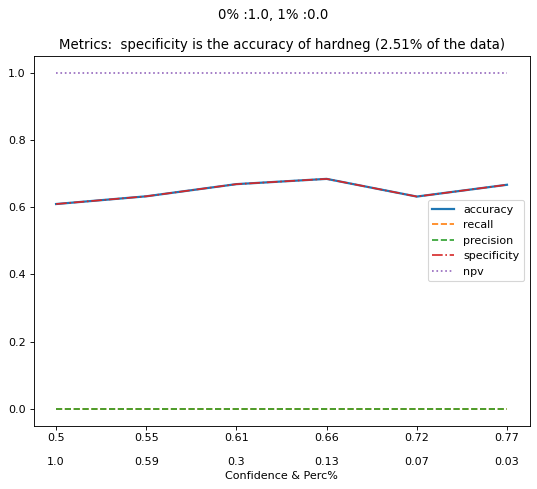

In [26]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.7066246056782335


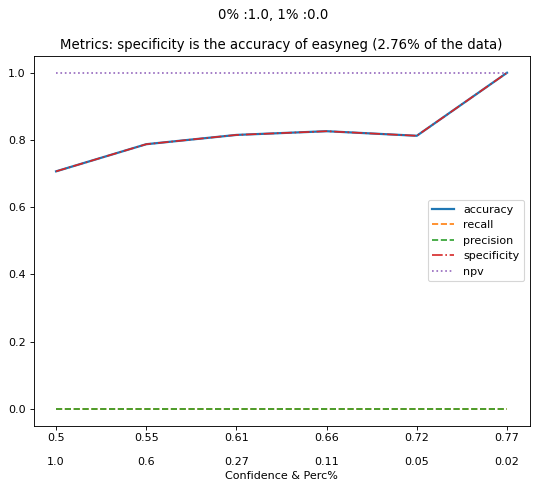

In [32]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

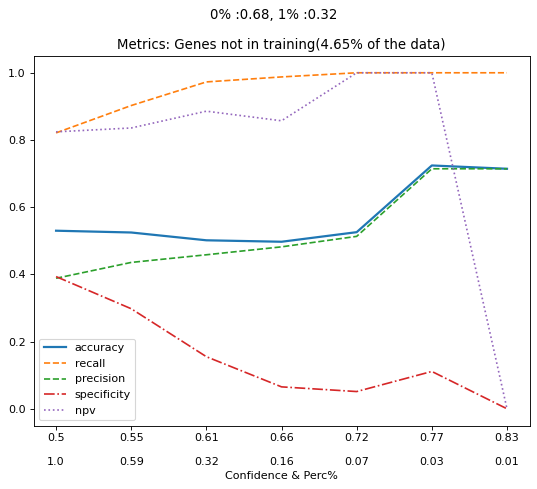

In [33]:
df_train = pd.DataFrame({'couples':gene_pairs_train})
regex = df_train['couples'].str.extractall('(.*)_(.*)_(.*)').reset_index()
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

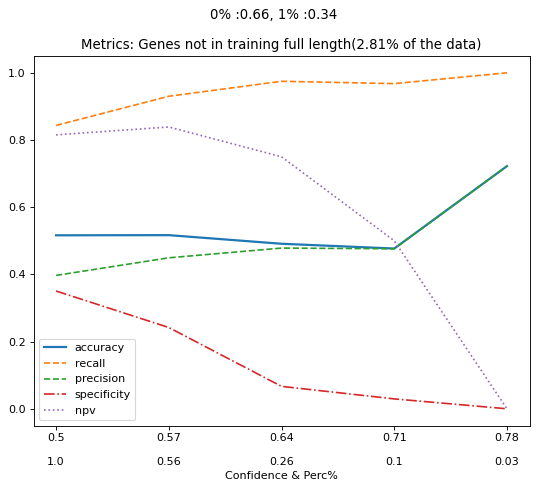

In [34]:
not_in_train_fl = not_in_train[(not_in_train.original_length1 <= MAX_RNA_SIZE)&(not_in_train.original_length2 <= MAX_RNA_SIZE)]
not_in_train_fl = not_in_train_fl[(not_in_train_fl.policy == 'easypos')|(not_in_train_fl.policy == 'smartneg')]
obtain_plot(not_in_train_fl, n_original_df = res.shape[0], title = f'Metrics: Genes not in training full length', n_conf = 8)

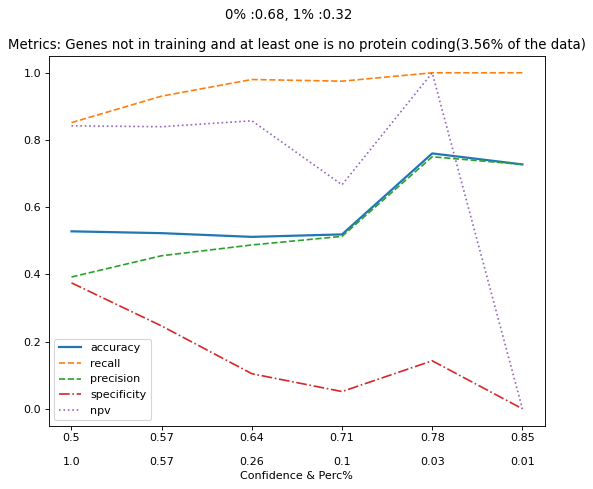

In [35]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

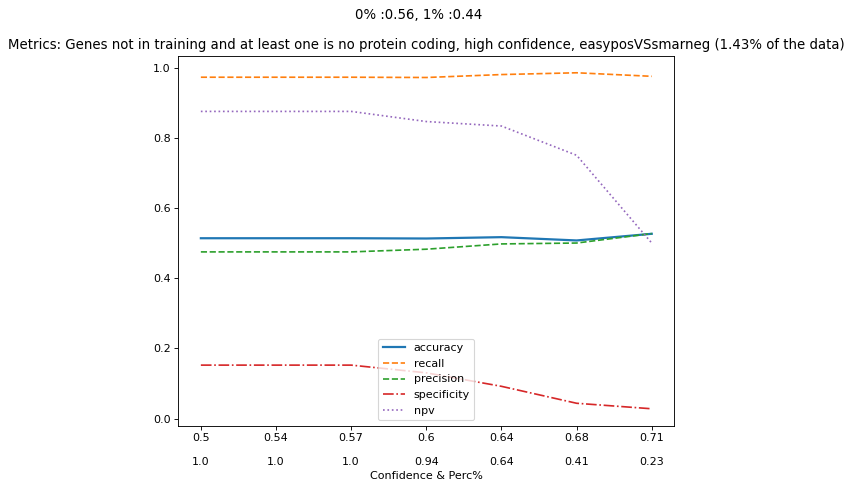

In [36]:
confidence_level = 0.6

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]
obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)

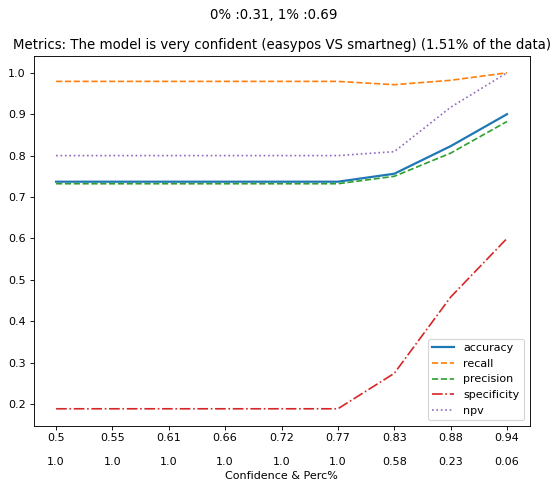

In [37]:
confidence_level = 0.8
high_prob_pairs = res[(res.probability>confidence_level)|(res.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)

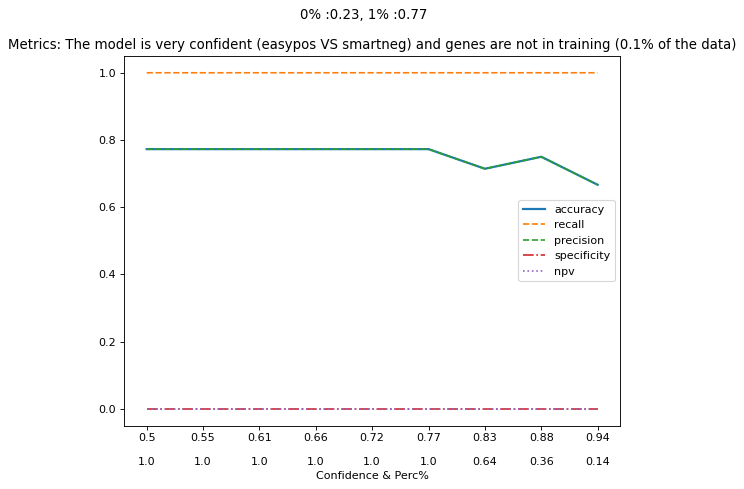

In [40]:
confidence_level = 0.8
high_prob_pairs = not_in_train[(not_in_train.probability>confidence_level)|(not_in_train.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) and genes are not in training ', n_conf = n_conf)

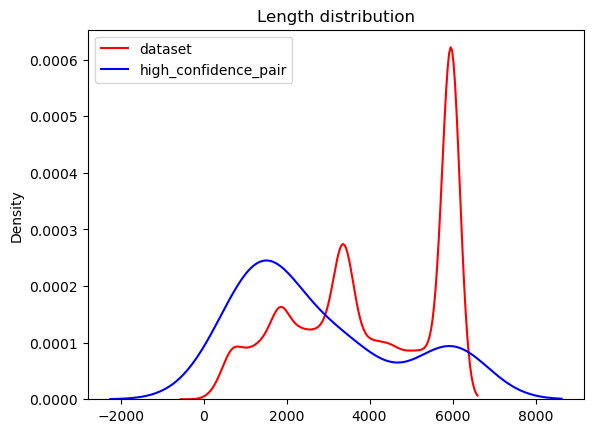

In [55]:
sns.kdeplot(list(pd.concat([easypos_smartneg.len_g1, easypos_smartneg.len_g2], axis = 0)), color = 'red', label = 'dataset')
sns.kdeplot(list(pd.concat([high_prob_pairs.len_g1, high_prob_pairs.len_g2], axis = 0)), color = 'blue', label = 'high_confidence_pair')
plt.title(f'Length distribution')
plt.legend()